# **Import necessary libraries**

In [ ]:
# Import necessary libraries for data loading, preprocessing, modeling, and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # For visualizing missing values
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, csr_matrix

# **Load and inspect the dataset**

In [ ]:
# Load the dataset
data = pd.read_csv('/content/sample_data/new_train_EGN5442.csv')

# Display first few rows to inspect the dataset
data.head()

,Unnamed: 0,y,x2,x3,x5,x9,x10,x11,x12,x13,...,x23,x24,x25,x26,x28,x29,x30,x31,x4,x6
0,0,1,#54359,Female,50,5,5,5,4,3,...,21,12.0,D_C,Bt,1,(192&&),NaN,2.380952,4,50
1,1,1,#84649,Female,44,1,1,1,1,3,...,0,0.0,L_C,Bt,1,(1034&&),NaN,inf,4,44
2,2,0,#59015,Female,72,3,1,5,5,3,...,0,8.0,L_C,Bt,3,(1452&&),NaN,inf,4,72
3,3,0,#99990,Female,38,1,3,1,3,5,...,0,0.0,L_C,PT,3,(916&&),NaN,inf,4,38
4,4,1,#83569,Male,37,5,5,5,5,2,...,0,0.0,L_C,Bt,1,(390&&),NaN,inf,4,37


# **Check and visualize missing values**

Missing values in each column:
 Unnamed: 0         0
y                  0
x2                 0
x3                 0
x5                 0
x9                 0
x10                0
x11                0
x12                0
x13                0
x14                0
x15                0
x16                0
x17                0
x18                0
x19                0
x20                0
x21                0
x22                0
x23                0
x24              312
x25                0
x26                0
x28                0
x29                0
x30           104722
x31                0
x4                 0
x6                 0
dtype: int64


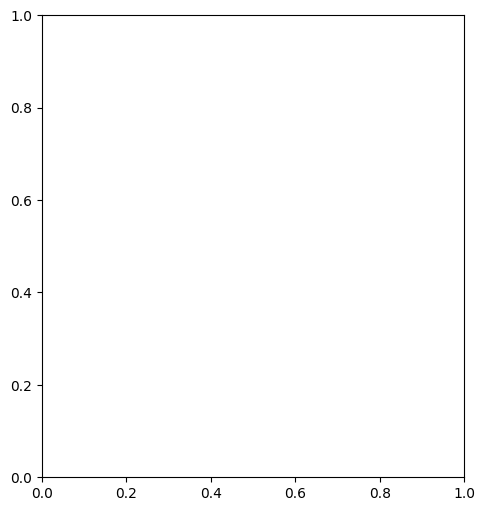

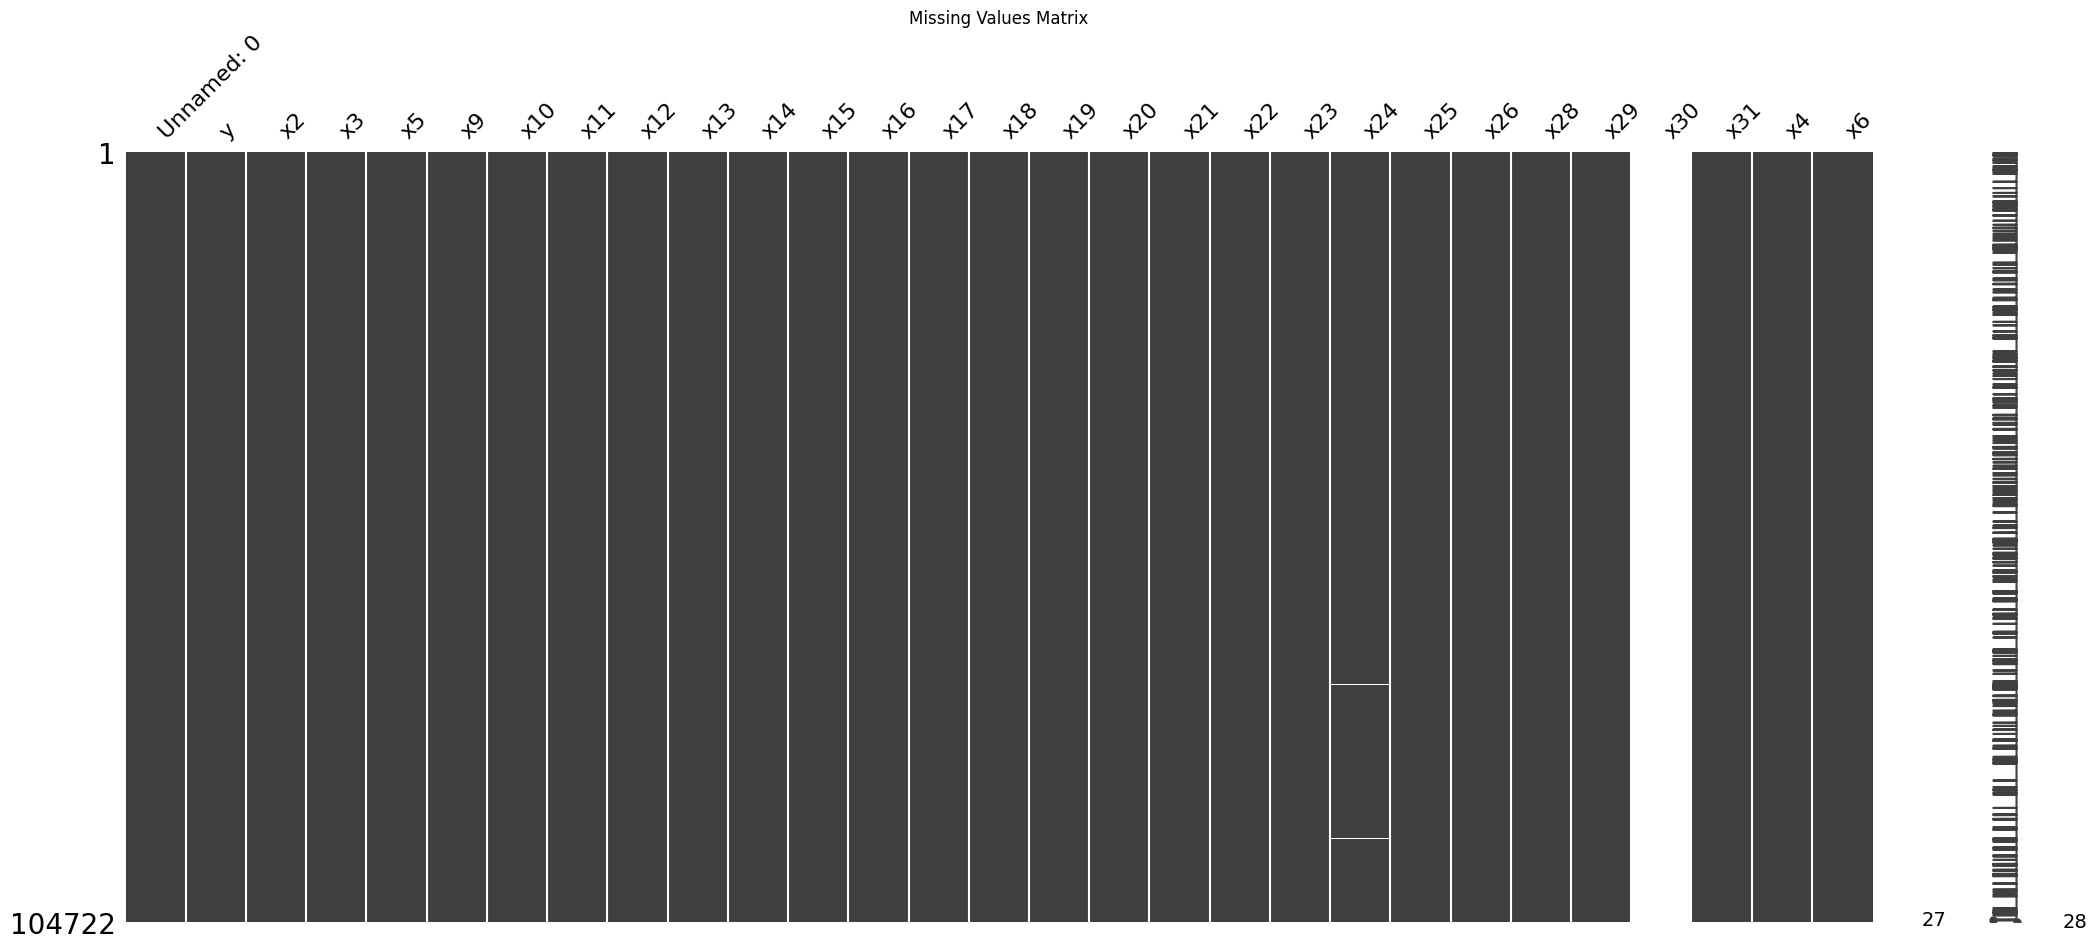

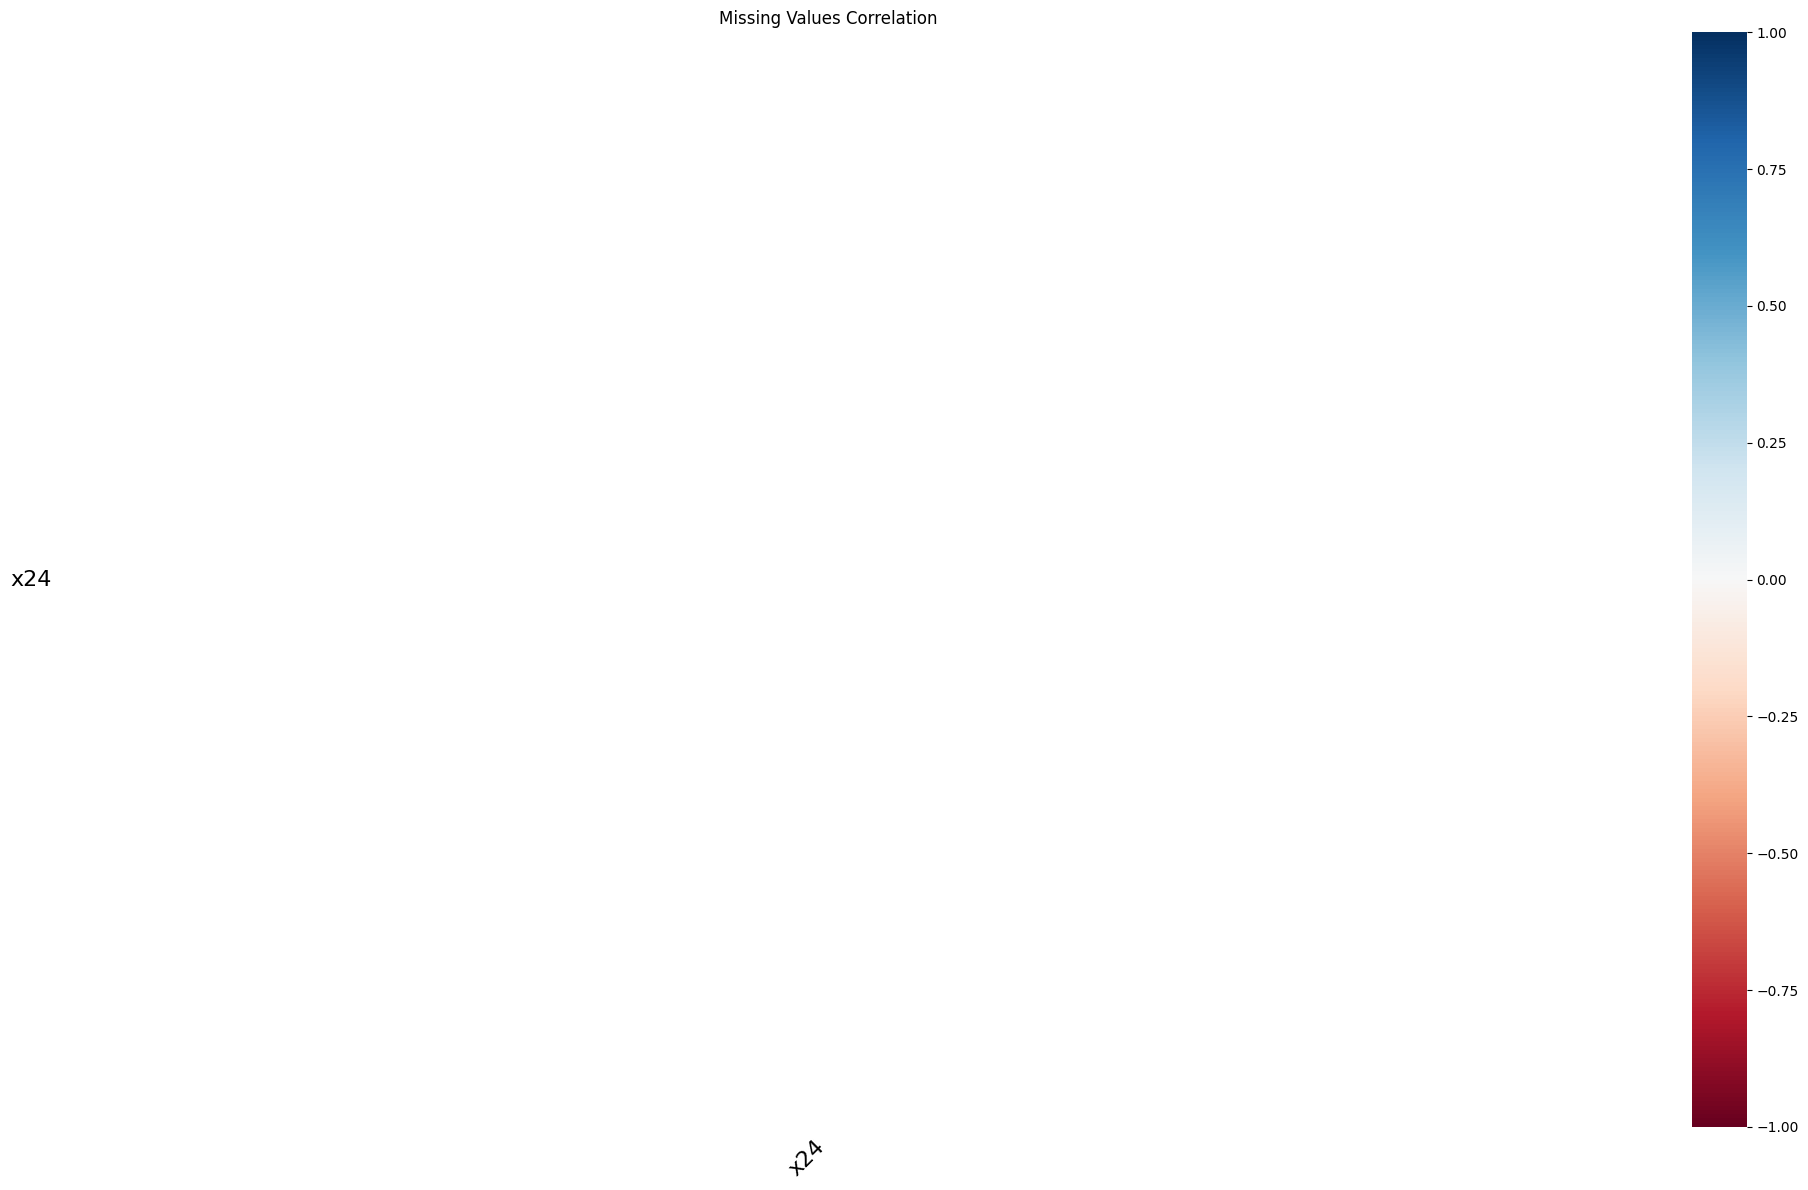

In [ ]:
# Check for missing values in each column
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Visualize missing values using missingno library
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
msno.matrix(data)
plt.title('Missing Values Matrix')

plt.subplot(1, 2, 2)
msno.heatmap(data)
plt.title('Missing Values Correlation')
plt.tight_layout()
plt.show()

# **Impute missing values**

In [ ]:
# Impute missing values in 'x24' with the median value
data['x24'] = data['x24'].fillna(data['x24'].median())

# Impute missing values in 'x30' with a constant value of 0
data['x30'] = data['x30'].fillna(0)

# Verify that missing values have been handled
missing_values_after_imputation = data.isnull().sum()
print("Missing values after imputation:\n", missing_values_after_imputation)

Missing values after imputation:
 Unnamed: 0    0
y             0
x2            0
x3            0
x5            0
x9            0
x10           0
x11           0
x12           0
x13           0
x14           0
x15           0
x16           0
x17           0
x18           0
x19           0
x20           0
x21           0
x22           0
x23           0
x24           0
x25           0
x26           0
x28           0
x29           0
x30           0
x31           0
x4            0
x6            0
dtype: int64


# **Identify categorical and numerical columns**

In [ ]:
# Identify categorical and numerical columns
categorical_columns = ['x2', 'x3', 'x25', 'x26', 'x29']
numerical_columns = [col for col in data.columns if col not in categorical_columns and col != 'y' and col != 'Unnamed: 0']

# **Clean categorical data**

In [ ]:
# Replace empty strings or whitespace-only strings with NaN and remove leading/trailing whitespaces
data[categorical_columns] = data[categorical_columns].replace(r'^\s*$', np.nan, regex=True)
data[categorical_columns] = data[categorical_columns].apply(lambda x: x.str.strip())

# Impute missing values in categorical columns with the mode
data[categorical_columns] = data[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))

# **Ensure numerical columns are correctly typed**

In [ ]:
# Convert numerical columns to numeric types
data[numerical_columns] = data[numerical_columns].apply(pd.to_numeric, errors='coerce')

# **Handle infinite values in numerical columns**

In [ ]:
# Replace infinite values with the maximum finite value of each column
data[numerical_columns] = data[numerical_columns].replace([np.inf, -np.inf], np.nan)
data[numerical_columns] = data[numerical_columns].apply(lambda x: x.fillna(x.max()))

# **Debug data types before transformation**

In [ ]:
print("Data types before transformation:\n", data.dtypes)

Data types before transformation:
 Unnamed: 0      int64
y               int64
x2             object
x3             object
x5              int64
x9              int64
x10             int64
x11             int64
x12             int64
x13             int64
x14           float64
x15             int64
x16             int64
x17             int64
x18             int64
x19             int64
x20             int64
x21             int64
x22             int64
x23             int64
x24           float64
x25            object
x26            object
x28             int64
x29            object
x30           float64
x31           float64
x4              int64
x6              int64
dtype: object


# **One-hot encode categorical variables and scale numerical variables**

In [ ]:
# One-hot encode categorical variables
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
categorical_data = categorical_transformer.fit_transform(data[categorical_columns])
print(f"Shape of categorical data after transformation: {categorical_data.shape}")

# Scale numerical variables
numerical_transformer = StandardScaler()
numerical_data = numerical_transformer.fit_transform(data[numerical_columns])
print(f"Shape of numerical data after transformation: {numerical_data.shape}")

Shape of categorical data after transformation: (104722, 107707)
Shape of numerical data after transformation: (104722, 22)


# **Combine transformed data**

In [ ]:
# Combine transformed data (using sparse matrix)
numerical_data_sparse = csr_matrix(numerical_data)
processed_data = hstack([numerical_data_sparse, categorical_data])
print(f"Shape of processed data after combining: {processed_data.shape}")

Shape of processed data after combining: (104722, 107729)


# **Apply dimensionality reduction**

In [ ]:
# Apply TruncatedSVD for dimensionality reduction
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10, random_state=42)
processed_data_reduced = svd.fit_transform(processed_data)

print(f"Shape of processed data after SVD: {processed_data_reduced.shape}")


Shape of processed data after SVD: (104722, 10)


# **Split data into train and test sets**

In [ ]:
# Split the data into train and test sets
X = processed_data_reduced
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Train and evaluate Logistic Regression model**

In [ ]:
# Train a Logistic Regression model with cross-validation
logistic_model = LogisticRegression(solver='liblinear', penalty='l1', max_iter=100, C=1)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(logistic_model, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"Logistic Regression Cross-Validation AUC Scores: {cv_results}")
print(f"Mean AUC Score: {cv_results.mean()}\n")

# Train the final Logistic Regression model
logistic_model.fit(X_train, y_train)

# Evaluate the Logistic Regression model
# Predict on the test set
y_pred = logistic_model.predict(X_test)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC AUC score
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

Logistic Regression Cross-Validation AUC Scores: [0.92178399 0.9179693  0.91920016 0.92135135 0.91971675]
Mean AUC Score: 0.9200043098088392

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87     11938
           1       0.84      0.80      0.82      9007

    accuracy                           0.85     20945
   macro avg       0.85      0.84      0.84     20945
weighted avg       0.85      0.85      0.85     20945

Confusion Matrix:
 [[10523  1415]
 [ 1764  7243]]
ROC AUC Score: 0.9177966196429972


# **Train and evaluate Random Forest model**

In [ ]:
# Train a Random Forest Classifier with cross-validation
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results_rf = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='roc_auc')
print(f"Random Forest Cross-Validation AUC Scores: {cv_results_rf}")
print(f"Mean AUC Score: {cv_results_rf.mean()}\n")

# Train the final Random Forest model
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest model
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Classification report
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:\n", conf_matrix_rf)

# ROC AUC score
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print("Random Forest ROC AUC Score:", roc_auc_rf)

Random Forest Cross-Validation AUC Scores: [0.95589036 0.95413141 0.95625669 0.95554695 0.95745983]
Mean AUC Score: 0.9558570450252402

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91     11938
           1       0.91      0.84      0.87      9007

    accuracy                           0.89     20945
   macro avg       0.90      0.89      0.89     20945
weighted avg       0.90      0.89      0.89     20945

Random Forest Confusion Matrix:
 [[11191   747]
 [ 1471  7536]]
Random Forest ROC AUC Score: 0.9561097032495509


# **Compare models**

In [ ]:
# Compare Models in Non-Technical Terms
print("\nModel Comparison Summary:")
if roc_auc_rf > roc_auc:
    print("The Random Forest model outperformed the Logistic Regression model in distinguishing between the two classes. This suggests that the Random Forest model may be more effective at making accurate predictions.")
else:
    print("The Logistic Regression model performed similarly or better than the Random Forest model, indicating that it may be sufficient for making predictions without adding complexity.")
print("Both models were evaluated on how well they differentiate between outcomes, and this helps in selecting the model that minimizes incorrect predictions.")


Model Comparison Summary:
The Random Forest model outperformed the Logistic Regression model in distinguishing between the two classes. This suggests that the Random Forest model may be more effective at making accurate predictions.
Both models were evaluated on how well they differentiate between outcomes, and this helps in selecting the model that minimizes incorrect predictions.


# **Visualize ROC curves**

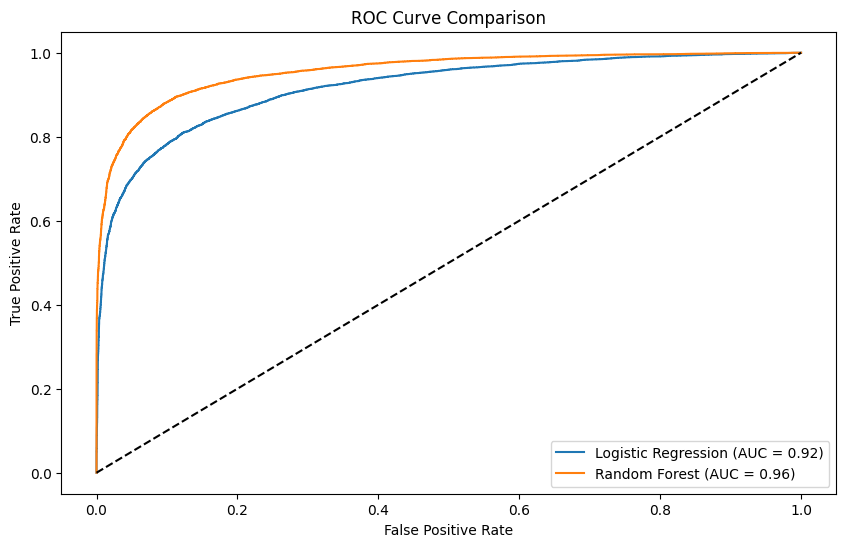

In [ ]:
#ROC Curve Visualization
plt.figure(figsize=(10, 6))
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, y_pred_proba)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(logistic_fpr, logistic_tpr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], 'k--') # Add diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# **Additional EDA visualizations**

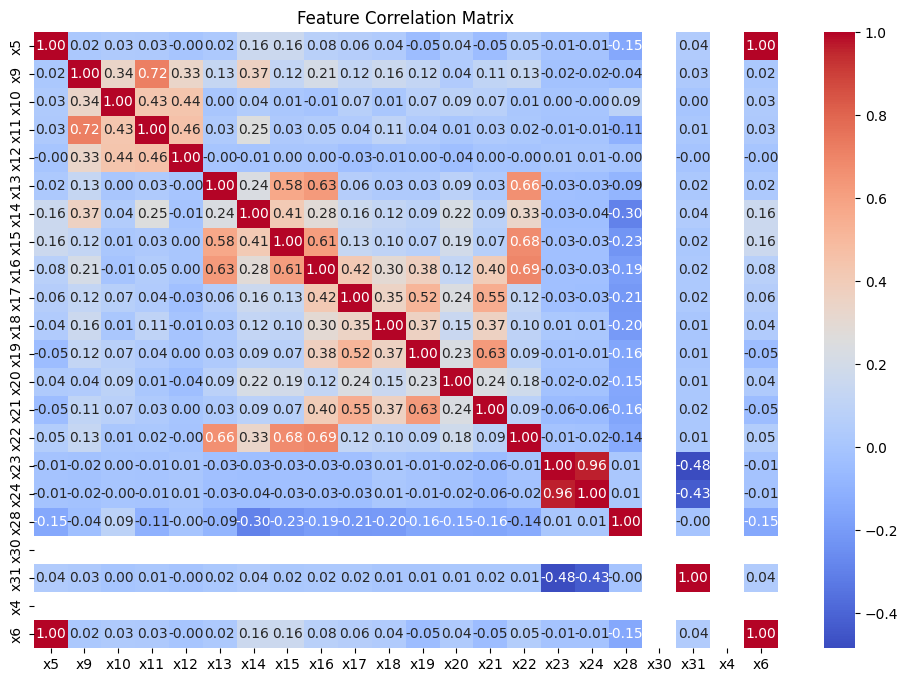

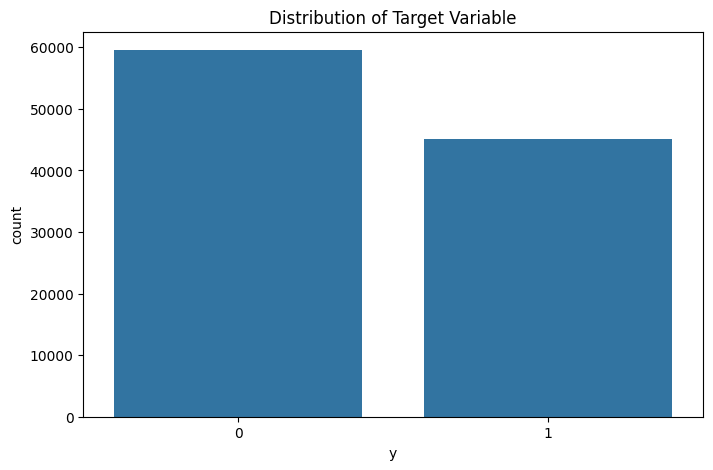

In [ ]:
# Correlation heatmap (for numerical columns only)
numerical_data_for_corr = data[numerical_columns]
plt.figure(figsize=(12, 8))
correlation = numerical_data_for_corr.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# Distribution of target variable
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='y')
plt.title('Distribution of Target Variable')
plt.show()

# **Additional Feature Selection using SHAP**

In [ ]:
!pip install shap==0.42.1

import shap

# Create a TreeExplainer object
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


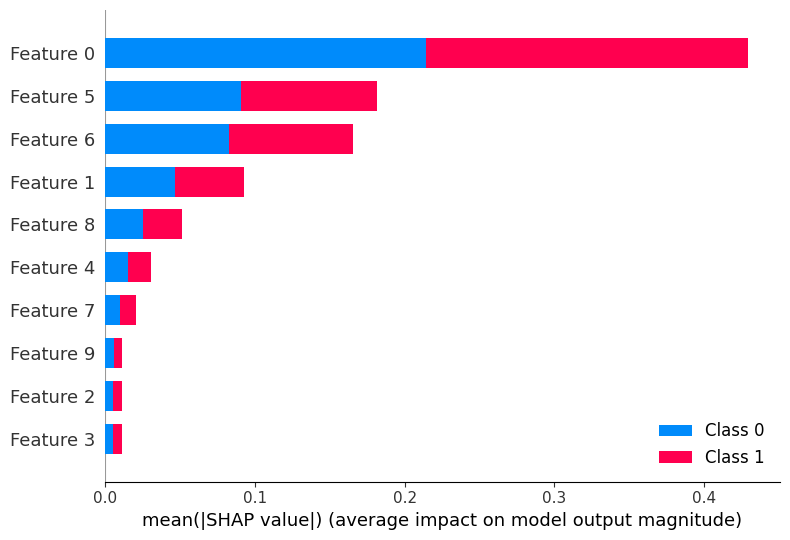

In [ ]:
# Summary plot
shap.summary_plot(shap_values, X_test)

Text(0.5, 1.0, 'AUC vs. Number of Features')

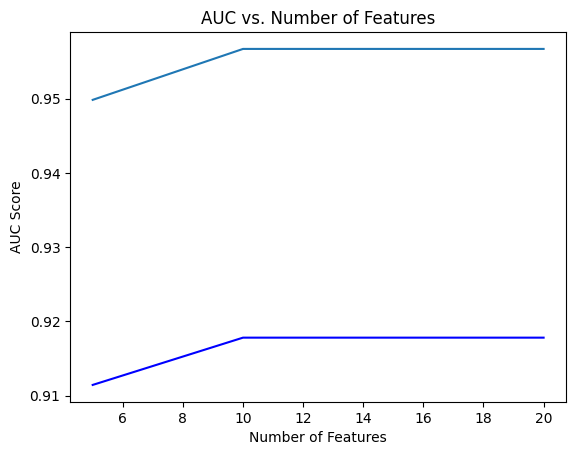

In [ ]:
# Feature importance and selection
importances = np.mean(np.abs(shap_values[1]), axis=0)
feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

num_features_list = [5, 10, 15, 20]

logistic_auc_scores = []
rf_auc_scores = []
logistic_metrics = []  # Storing metrics for each iteration
rf_metrics = []       # Storing metrics for each iteration

for num_features in num_features_list:
    top_features = feature_importance_df['feature'][:num_features].tolist()
    X_train_selected = X_train[:, [feature_names.index(f) for f in top_features]]
    X_test_selected = X_test[:, [feature_names.index(f) for f in top_features]]

    # Logistic Regression
    logistic_model = LogisticRegression(solver='liblinear', penalty='l1', max_iter=100, C=1)
    logistic_model.fit(X_train_selected, y_train)
    y_pred_proba = logistic_model.predict_proba(X_test_selected)[:, 1]
    logistic_auc_scores.append(roc_auc_score(y_test, y_pred_proba))

    # Store metrics for Logistic Regression
    y_pred = logistic_model.predict(X_test_selected)
    logistic_metrics.append({
        'num_features': num_features,
        'auc': roc_auc_score(y_test, y_pred_proba),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'fpr': roc_curve(y_test, y_pred_proba)[0],
        'tpr': roc_curve(y_test, y_pred_proba)[1]
    })

    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
    rf_model.fit(X_train_selected, y_train)
    y_pred_proba_rf = rf_model.predict_proba(X_test_selected)[:, 1]
    rf_auc_scores.append(roc_auc_score(y_test, y_pred_proba_rf))

    # Store metrics for Random Forest
    y_pred_rf = rf_model.predict(X_test_selected)
    rf_metrics.append({
        'num_features': num_features,
        'auc': roc_auc_score(y_test, y_pred_proba_rf),
        'confusion_matrix': confusion_matrix(y_test, y_pred_rf),
        'fpr': roc_curve(y_test, y_pred_proba_rf)[0],
        'tpr': roc_curve(y_test, y_pred_proba_rf)[1]
    })



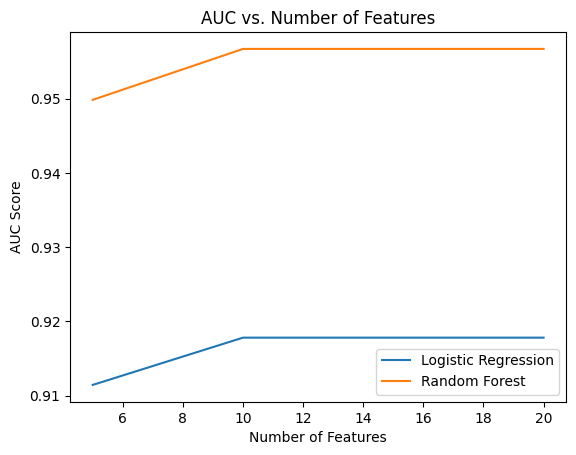

In [ ]:
# Plot AUC scores
plt.plot(num_features_list, logistic_auc_scores, label='Logistic Regression')
plt.plot(num_features_list, rf_auc_scores, label='Random Forest')
plt.xlabel('Number of Features')
plt.ylabel('AUC Score')
plt.title('AUC vs. Number of Features')
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features (degree=2 for this case)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Re-train and evaluate models with polynomial features
logistic_auc_scores_poly = []
rf_auc_scores_poly = []
logistic_metrics_poly = []  # Store metrics for each iteration
rf_metrics_poly = []       # Store metrics for each iteration

for num_features in num_features_list:
    # Feature selection (using original feature importances - consider recalculating for poly features)
    top_features = feature_importance_df['feature'][:num_features].tolist()

    # Adjust feature indices for polynomial features
    poly_feature_names = poly.get_feature_names_out(feature_names)
    selected_poly_features = [np.where(poly_feature_names == f)[0][0] for f in top_features if f in poly_feature_names]

    X_train_selected_poly = X_train_poly[:, selected_poly_features]
    X_test_selected_poly = X_test_poly[:, selected_poly_features]

    # Logistic Regression with polynomial features
    logistic_model_poly = LogisticRegression(solver='liblinear', penalty='l1', max_iter=100, C=1)
    logistic_model_poly.fit(X_train_selected_poly, y_train)
    y_pred_proba_poly = logistic_model_poly.predict_proba(X_test_selected_poly)[:, 1]
    logistic_auc_scores_poly.append(roc_auc_score(y_test, y_pred_proba_poly))

    # Store metrics for Logistic Regression with polynomial features
    y_pred_poly = logistic_model_poly.predict(X_test_selected_poly)
    logistic_metrics_poly.append({
        'num_features': num_features,
        'auc': roc_auc_score(y_test, y_pred_proba_poly),
        'confusion_matrix': confusion_matrix(y_test, y_pred_poly),
        'fpr': roc_curve(y_test, y_pred_proba_poly)[0],
        'tpr': roc_curve(y_test, y_pred_proba_poly)[1]
    })

    # Random Forest with polynomial features
    rf_model_poly = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
    rf_model_poly.fit(X_train_selected_poly, y_train)
    y_pred_proba_rf_poly = rf_model_poly.predict_proba(X_test_selected_poly)[:, 1]
    rf_auc_scores_poly.append(roc_auc_score(y_test, y_pred_proba_rf_poly))

    # Store metrics for Random Forest with polynomial features
    y_pred_rf_poly = rf_model_poly.predict(X_test_selected_poly)
    rf_metrics_poly.append({
        'num_features': num_features,
        'auc': roc_auc_score(y_test, y_pred_proba_rf_poly),
        'confusion_matrix': confusion_matrix(y_test, y_pred_rf_poly),
        'fpr': roc_curve(y_test, y_pred_proba_rf_poly)[0],
        'tpr': roc_curve(y_test, y_pred_proba_rf_poly)[1]
    })



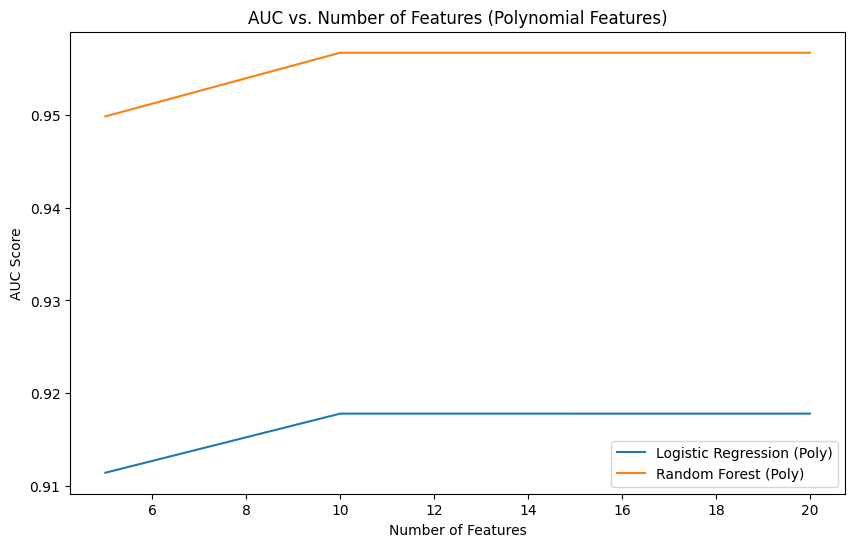

In [ ]:
# Plot AUC scores for models with polynomial features
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, logistic_auc_scores_poly, label='Logistic Regression (Poly)')
plt.plot(num_features_list, rf_auc_scores_poly, label='Random Forest (Poly)')
plt.xlabel('Number of Features')
plt.ylabel('AUC Score')
plt.title('AUC vs. Number of Features (Polynomial Features)')
plt.legend()
plt.show()

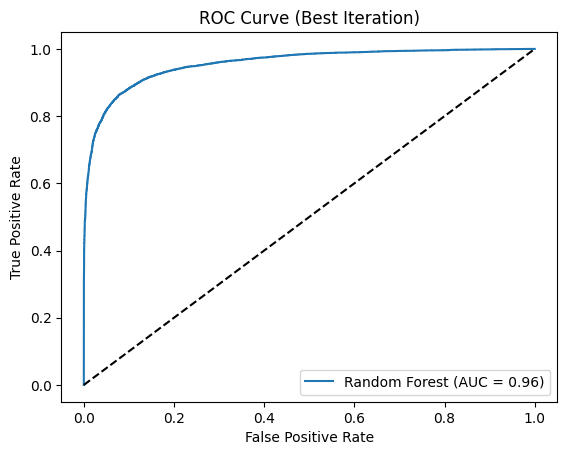

In [ ]:
# Find best iteration (e.g., for Random Forest)
best_iteration = np.argmax(rf_auc_scores)
# Plot ROC curve for the best iteration
plt.plot(rf_metrics[best_iteration]['fpr'], rf_metrics[best_iteration]['tpr'],
         label='Random Forest (AUC = {:.2f})'.format(rf_metrics[best_iteration]['auc']))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Best Iteration)')
plt.legend()
plt.show()

# **Checking Overfitting Problem in Random Forest Model**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Reduced parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}

# Use RandomizedSearchCV for faster hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, verbose=1),
    param_distributions=param_grid,
    n_iter=10,  # Limit to 10 parameter
    cv=3,  #
    scoring='roc_auc',
    n_jobs=-1,
    verbose=3  # Verbose level for RandomizedSearchCV to show detailed progress
)

# Fit the model and observe the output for indications of progress
random_search.fit(X_train, y_train)
print(f"Best hyperparameters for Random Forest: {random_search.best_params_}")

# Train the final Random Forest model with the best parameters
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Evaluate the tuned Random Forest model & Predict on the test set
y_pred_rf_best = best_rf_model.predict(X_test)

# Classification report
print("Tuned Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf_best))
# Confusion matrix
conf_matrix_rf_best = confusion_matrix(y_test, y_pred_rf_best)
print("Tuned Random Forest Confusion Matrix:\n", conf_matrix_rf_best)
# ROC AUC score
y_pred_proba_rf_best = best_rf_model.predict_proba(X_test)[:, 1]
roc_auc_rf_best = roc_auc_score(y_test, y_pred_proba_rf_best)
print("Tuned Random Forest ROC AUC Score:", roc_auc_rf_best)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


invalid value encountered in cast
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   26.3s


Best hyperparameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 15}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   24.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Tuned Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     11938
           1       0.92      0.86      0.89      9007

    accuracy                           0.91     20945
   macro avg       0.91      0.90      0.91     20945
weighted avg       0.91      0.91      0.91     20945

Tuned Random Forest Confusion Matrix:
 [[11245   693]
 [ 1230  7777]]
Tuned Random Forest ROC AUC Score: 0.9658696053736653


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
